# Init

In [2]:
import collections


## Dataset-specific -- edit me
data_number = "082"
data_name = "Final"

treatments = collections.OrderedDict()
treatments['control'] = 'control'
treatments['noreward'] = 'benign'
treatments['punish'] = 'harsh'

## basic config
#base_path = "/home/rosiec/Dropbox/School_Docs/Papers/ALife\ CE\ Paper/alife2016/evo_mod/"
#base_path = "/home/rosiec/Dropbox/School_Docs/Papers/Journal\ CE\ Paper/data_analysis/"
base_path = "/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/"


raw_data_directory = "raw_data"
analysis_directory = "intermediate_data"
scripts_path = "~/Dropbox/School_Docs/Research/research_scripts/"

## generated
data_directory = data_number + "_" + "_".join(data_name.split(" "))
data_path = base_path + raw_data_directory + "/" + data_directory
analysis_path = base_path + analysis_directory

print (data_path)
print (analysis_path)



/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/raw_data/082_Final
/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/intermediate_data


In [3]:
%cd {data_path}
%mkdir {analysis_path}
%cd {analysis_path}
%pwd


/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/raw_data/082_Final
mkdir: cannot create directory ‘/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/intermediate_data’: File exists
/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/intermediate_data


u'/Core/home/rosiec/Dropbox/School_Docs/Papers/Journal_CE_Paper/data_analysis/intermediate_data'

In [4]:
import glob


import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy  
import scikits.bootstrap as bootstrap
from scipy import stats
import matplotlib.gridspec as gridspec
#from IPython.display import Image
from PIL import Image
from IPython.display import Image as ipyImage

%matplotlib inline
%rehashx
pd.__version__

u'0.20.3'

In [5]:
import sys
sys.path.append({scripts_path})
%run {scripts_path}/quickplot.py --help

Usage: quickplot.py [options] outfile [input_file1 column1 "directory_glob1" name1 .. input_fileN columnN "directory_globN" nameN] 
          


Options:
  -h, --help            show this help message and exit
  -v, --verbose         print extra messages to stdout
  -d, --debug_messages  print debug messages to stdout
  --plotonly            Skip the aggregation step, and plot only, using
                        existing data files.
  --noplot              Skip the plotting step, only aggregate the data files.
  -t TITLE, --title=TITLE
                        set a different title than outfile (default)
  -x XLABEL, --xlabel=XLABEL
                        X-axis Label
  -y YLABEL, --ylabel=YLABEL
                        Y-axis Label
  --include_chevrons    Include line marker glyphs in addition to color
  --chevrons_by_members
                        Make the chevrons track by members, along with line
                        style
  --data_members=MEMBER_COUNT
                        N

# D_g & D_p filtered

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


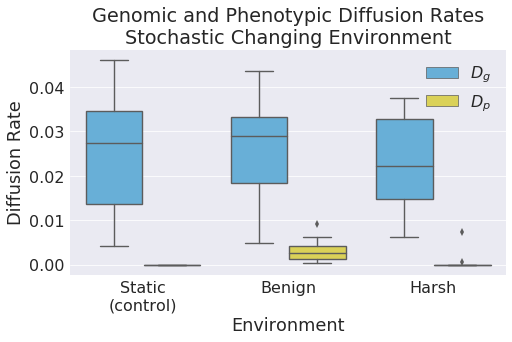

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:2764: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


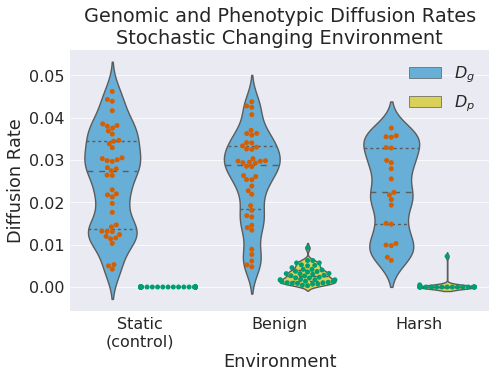

In [6]:
subdir = "../200_StochasticCE/"

tname = {"control": "Static\n(control)",
        "noreward": "Benign",
        "punish": "Harsh"}    
    
## CALCULATE Genomic Diffusion Rate and Phenotypic Diffusion Rate
fields = ["num_cpus", "lethal", "deleterious", "neutral", "beneficial", 
          "same_p_lethal", "same_p_deleterious", "same_p_neutral", "same_p_beneficial", 
          "diff_p_lethal", "diff_p_deleterious", "diff_p_neutral", "diff_p_beneficial",
          "whitenodes_lethal", "whitenodes_deleterious", "whitenodes_neutral", "whitenodes_beneficial", 
          "blacknodes_lethal", "blacknodes_deleterious", "blacknodes_neutral", "blacknodes_beneficial", 
          "ancestor_phenotype"
         ]
## defaults
mu = 0.00075 # per-site copy mutation rate -- R_c in the paper
l = 121 # genome length
D = 26 # inst-set size        
### Fidelity -- probability of birthing a genetically unchanged offspring
F = (1 - mu)**l

dfs = []
dfs_joint = []

for t in treatments:  
    
    D_gs = []
    D_ps = []

    for i in range(1, 50): 
        bit = str(i).zfill(2)
        filepath = data_path + "/" + subdir + "/network_metrics_wholepop/metrics"
        filepath = filepath.replace("\\", "")
        final = filepath + '/*' + t + "*_2000" + bit + '_*.network_metrics.csv'
        
        #print final
        
        dfiles = sorted(glob.glob(final))

        #print dfiles
        #print
        
        D_g_pair = []
        D_p_pair = []
        for item in dfiles:
            #print item

            dta = pd.read_csv(item, header=None, comment="#", 
                              delimiter=",",
                              skipinitialspace=True, 
                              names=fields, usecols=range(0,len(fields)))
    
            #print dta.head()
            #break
            
            
            #print "GOODBYE"
            filtered = dta[dta.apply(
                lambda x: int(x['ancestor_phenotype']) & 1 == 1, 
                axis=1)]

            #print "DONE"
            
            if len(filtered) == 0:
                continue
            
            #print "HELLO", t, i, dta['ancestor_phenotype'][0], len(dta['ancestor_phenotype']), len(filtered['ancestor_phenotype'])
            
            dta = filtered
    
            nu_g = np.mean(dta['neutral'] + dta['beneficial'])
            nu_p = np.mean(dta['same_p_neutral'] + dta['same_p_beneficial'])
            #print dta.head()

            f_c_prob_nonneut = mu * (1 - nu_g)
            F_neut = (1 - f_c_prob_nonneut)**l

            f_cp_prob_nonneut_diffphen = mu * (1 - nu_p)
            F_pheno = (1 - f_cp_prob_nonneut_diffphen)**l

            #print nu_g, nu_p
            #print F_neut, F_pheno

            aD_g = F_neut - F
            aD_p = F_neut - F_pheno        

            D_g_pair.append(aD_g)
            D_p_pair.append(aD_p)
        #break
        if len(dfiles) > 1 or (len(dfiles) == 1 and t == "control"): ## make sure there's something here            
            D_g = np.mean(D_g_pair)
            D_p = np.mean(D_p_pair)

            D_gs.append(D_g)
            D_ps.append(D_p)

    dta = pd.DataFrame()
    dta['Diffusion Rate'] = D_gs
    dta['Metric'] = [r'$D_g$']*len(D_gs)
    dta['Environment'] = [tname[t]]*len(D_gs)    
    dfs.append(dta)

    dta = pd.DataFrame()
    dta['Diffusion Rate'] = D_ps
    dta['Metric'] = [r'$D_p$']*len(D_ps)
    dta['Environment'] = [tname[t]]*len(D_ps)
    dfs.append(dta)
   
    
diffusion_rates_201_wholepop = pd.concat(dfs, axis=0)
#print diffusion_rates_201_wholepop.head()  
#print diffusion_rates_201_wholepop.tail()  

sns.set(#style="whitegrid", 
    color_codes=True, palette="colorblind")

sns.set_context('paper', font_scale=2)
g = sns.factorplot(x="Environment", y="Diffusion Rate",
                   hue="Metric",
                   data=diffusion_rates_201_wholepop,
                   size=5, aspect=1.5, #
                   palette={r'$D_g$': "c", 
                            r'$D_p$': "y"},
                   kind="box", 
                   legend=False
              )
plt.subplots_adjust(top=0.85)

titles = ["Genomic and Phenotypic Diffusion Rates\nStochastic Changing Environment"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    #ax.set_ylim([0,0.35])
    #ax.set_ylabel("Diffusion Rate")
    
L=plt.legend(loc="upper right")#, bbox_to_anchor=(1.05, 1))#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

sns.set_context('paper', font_scale=2)
plt.rcParams['figure.figsize'] = (7.5, 5)

g = sns.violinplot(x="Environment", y="Diffusion Rate",
                   hue="Metric",
                   data=diffusion_rates_201_wholepop,
                   #size=5, aspect=1.5, #
                   palette={r'$D_g$': "c", 
                            r'$D_p$': "y"},
                   #kind="violin", 
                   #legend=False
                   scale="count", 
#                    scale_hue=True, 
                    bw=.3, 
                    inner="quart",
              )
sns.swarmplot(x="Environment", y="Diffusion Rate",
                   hue="Metric",
                   data=diffusion_rates_201_wholepop,
                   size=5, #aspect=1.5, #
                   palette={r'$D_g$': "r", 
                            r'$D_p$': "g"},
                   #kind="violin", 
                  split = True,
                   #legend=False,
                ax=g
              )
plt.subplots_adjust(top=0.85)


#titles = ["Genomic and Phenotypic Diffusion Rates\nStochastic Changing Environment"]
#for ax, title in zip(g.axes.flat, titles):
#    ax.set_title(title)
g.set_title("Genomic and Phenotypic Diffusion Rates\nStochastic Changing Environment")
    #ax.set_ylim([0,0.35])
    #ax.set_ylabel("Diffusion Rate")
    
#L=plt.legend(loc="upper right")#, bbox_to_anchor=(1.05, 1))#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
handles, labels = ax.get_legend_handles_labels()
g.legend(handles[:2], labels[:2], loc='upper right')



# Stats

In [7]:
## Collect Cyclic Stats
subdir = "../201_CyclicCE/"

tname = {"control": "Static\n(control)",
        "noreward": "Benign",
        "punish": "Harsh"}    
    
## CALCULATE Genomic Diffusion Rate and Phenotypic Diffusion Rate
fields = ["num_cpus", "lethal", "deleterious", "neutral", "beneficial", 
          "same_p_lethal", "same_p_deleterious", "same_p_neutral", "same_p_beneficial", 
          "diff_p_lethal", "diff_p_deleterious", "diff_p_neutral", "diff_p_beneficial"]
## defaults
mu = 0.00075 # per-site copy mutation rate -- R_c in the paper
l = 121 # genome length
D = 26 # inst-set size        
### Fidelity -- probability of birthing a genetically unchanged offspring
F = (1 - mu)**l

dfs = []
dfs_joint = []

for t in treatments:  
    
    D_gs = []
    D_ps = []

    for i in range(1, 50): 
        bit = str(i).zfill(2)
        filepath = data_path + "/" + subdir + "/network_metrics_wholepop/metrics"
        filepath = filepath.replace("\\", "")
        final = filepath + '/*' + t + "*_2010" + bit + '_*.network_metrics.csv'
        
        dfiles = sorted(glob.glob(final))

        D_g_pair = []
        D_p_pair = []
        for item in dfiles:
            dta = pd.read_csv(item, header=None, comment="#", 
                              delimiter=",",
                              skipinitialspace=True, 
                              names=fields, usecols=range(0,len(fields)))
    
            nu_g = np.mean(dta['neutral'] + dta['beneficial'])
            nu_p = np.mean(dta['same_p_neutral'] + dta['same_p_beneficial'])

            f_c_prob_nonneut = mu * (1 - nu_g)
            F_neut = (1 - f_c_prob_nonneut)**l

            f_cp_prob_nonneut_diffphen = mu * (1 - nu_p)
            F_pheno = (1 - f_cp_prob_nonneut_diffphen)**l

            aD_g = F_neut - F
            aD_p = F_neut - F_pheno        

            D_g_pair.append(aD_g)
            D_p_pair.append(aD_p)
            
        if len(dfiles) > 1 or (len(dfiles) == 1 and t == "control"): ## make sure there's something here            
            D_g = np.mean(D_g_pair)
            D_p = np.mean(D_p_pair)

            D_gs.append(D_g)
            D_ps.append(D_p)

    dta = pd.DataFrame()
    dta['Diffusion Rate'] = D_gs
    dta['Metric'] = [r'$D_g$']*len(D_gs)
    dta['Environment'] = [tname[t]]*len(D_gs)    
    dfs.append(dta)

    dta = pd.DataFrame()
    dta['Diffusion Rate'] = D_ps
    dta['Metric'] = [r'$D_p$']*len(D_ps)
    dta['Environment'] = [tname[t]]*len(D_ps)
    dfs.append(dta)
    
cyclic_diffusion_rates = pd.concat(dfs, axis=0)
#print diffusion_rates_201_wholepop.head()  
#print diffusion_rates_201_wholepop.tail()  

In [8]:
def mww(a, b, nameA, nameB, title, field):
    print
    print title + " - " + nameA + " vs " + nameB
    print "-----------------"
    print stats.ranksums(a[field], b[field]) 
    z_stat, p_val = stats.ranksums(a[field], b[field])  

    #print (z_stat)
    #print (p_val)

    if p_val < (0.05/3): #bonferroni
        print ("reject null of sameness (different)")
    else:
        print ("can't reject null of sameness")
    print "medians"
    print nameA, a[field].median()
    print nameB, b[field].median()

def kruskal(a, b, c, field=None, verbose=False):
    x = a[field].dropna()
    y = b[field].dropna()
    #z = []
    #if c != None:
    z = c[field].dropna()    

    if verbose:
        print a[field].describe()
        print b[field].describe()
        print c[field].describe()
        print
        print x
        print y
        print z
    
    #if c:
    print stats.kruskal(x, y, z)
    ##else:
    #    print stats.kruskal(x, y)

In [9]:
dat = diffusion_rates_201_wholepop.loc[diffusion_rates_201_wholepop['Metric'] == '$D_p$']

a = dat.loc[dat['Environment'] == 'Static\n(control)']
b = dat.loc[dat['Environment'] == 'Benign']
c = dat.loc[dat['Environment'] == 'Harsh']

print a.head()
print b.head()
print c.head()

   Diffusion Rate Metric        Environment
0             0.0  $D_p$  Static\n(control)
1             0.0  $D_p$  Static\n(control)
2             0.0  $D_p$  Static\n(control)
3             0.0  $D_p$  Static\n(control)
4             0.0  $D_p$  Static\n(control)
   Diffusion Rate Metric Environment
0        0.001697  $D_p$      Benign
1        0.002615  $D_p$      Benign
2        0.000417  $D_p$      Benign
3        0.006255  $D_p$      Benign
4        0.000712  $D_p$      Benign
   Diffusion Rate Metric Environment
0             0.0  $D_p$       Harsh
1             0.0  $D_p$       Harsh
2             NaN  $D_p$       Harsh
3             0.0  $D_p$       Harsh
4             NaN  $D_p$       Harsh


In [10]:
mww(a, b, "Static", 'Benign', '$D_p$', 'Diffusion Rate')
mww(a, c, "Static", 'Harsh', '$D_p$', 'Diffusion Rate')



$D_p$ - Static vs Benign
-----------------
RanksumsResult(statistic=-8.0761822107431183, pvalue=6.6826004099146645e-16)
reject null of sameness (different)
medians
Static 0.0
Benign 0.0026399015757

$D_p$ - Static vs Harsh
-----------------
RanksumsResult(statistic=-4.8627647669197485, pvalue=1.1575738484403444e-06)
reject null of sameness (different)
medians
Static 0.0
Harsh 0.0


In [11]:
dat = diffusion_rates_201_wholepop.loc[
    diffusion_rates_201_wholepop['Metric'] == '$D_g$']

a = dat.loc[dat['Environment'] == 'Static\n(control)'].dropna()
b = dat.loc[dat['Environment'] == 'Benign'].dropna()
c = dat.loc[dat['Environment'] == 'Harsh'].dropna()

#print a.head()
#print b.head()
#print c.head()

mww(a, b, "Static", 'Benign', '$D_g$', 'Diffusion Rate')
mww(a, c, "Static", 'Harsh', '$D_g$', 'Diffusion Rate')

kruskal(a, b, c, field="Diffusion Rate")



$D_g$ - Static vs Benign
-----------------
RanksumsResult(statistic=-0.21095691516794077, pvalue=0.83292089144167536)
can't reject null of sameness
medians
Static 0.0274329738382
Benign 0.0288757800188

$D_g$ - Static vs Harsh
-----------------
RanksumsResult(statistic=0.87935691950040573, pvalue=0.37920778279911482)
can't reject null of sameness
medians
Static 0.0274329738382
Harsh 0.022325750235
KruskalResult(statistic=1.1104881102256172, pvalue=0.57393217302128252)


In [12]:
dat = diffusion_rates_201_wholepop.loc[diffusion_rates_201_wholepop['Metric'] == '$D_p$']

b = dat.loc[dat['Environment'] == 'Benign'].dropna()
c = dat.loc[dat['Environment'] == 'Harsh'].dropna()

dat_cyclic = cyclic_diffusion_rates.loc[
    cyclic_diffusion_rates['Metric'] == '$D_p$']

c_c = dat_cyclic.loc[dat_cyclic['Environment'] == 'Harsh'].dropna()
c_b = dat_cyclic.loc[dat_cyclic['Environment'] == 'Benign'].dropna()

print c.dropna().head()
print c_c.head()

#print a.head()
#print b.head()
#print c.head()

mww(c, c_c, "Stoch", 'Cyclic', 'Harsh $D_p$', 'Diffusion Rate')
mww(b, c_b, "Stoch", 'Cyclic', 'Benign $D_p$', 'Diffusion Rate')


    Diffusion Rate Metric Environment
0              0.0  $D_p$       Harsh
1              0.0  $D_p$       Harsh
3              0.0  $D_p$       Harsh
5              0.0  $D_p$       Harsh
10             0.0  $D_p$       Harsh
   Diffusion Rate Metric Environment
0        0.007489  $D_p$       Harsh
1        0.004694  $D_p$       Harsh
2        0.002879  $D_p$       Harsh
3        0.005994  $D_p$       Harsh
4        0.001006  $D_p$       Harsh

Harsh $D_p$ - Stoch vs Cyclic
-----------------
RanksumsResult(statistic=-6.1965540140531452, pvalue=5.7712730172710909e-10)
reject null of sameness (different)
medians
Stoch 0.0
Cyclic 0.00587239400693

Benign $D_p$ - Stoch vs Cyclic
-----------------
RanksumsResult(statistic=2.2041937794475408, pvalue=0.027510719067709001)
can't reject null of sameness
medians
Stoch 0.0026399015757
Cyclic 0.00177621603291


## Unfiltered

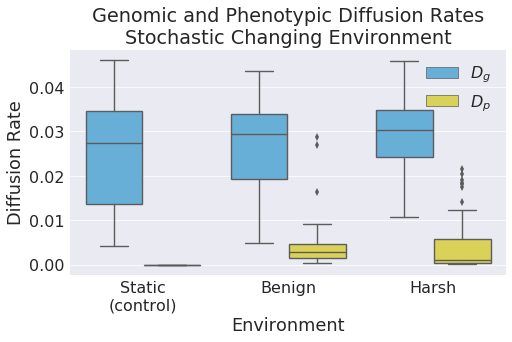

In [13]:
subdir = "../200_StochasticCE/"

tname = {"control": "Static\n(control)",
        "noreward": "Benign",
        "punish": "Harsh"}    
    
## CALCULATE Genomic Diffusion Rate and Phenotypic Diffusion Rate
fields = ["num_cpus", "lethal", "deleterious", "neutral", "beneficial", 
          "same_p_lethal", "same_p_deleterious", "same_p_neutral", "same_p_beneficial", 
          "diff_p_lethal", "diff_p_deleterious", "diff_p_neutral", "diff_p_beneficial",
         ]
## defaults
mu = 0.00075 # per-site copy mutation rate -- R_c in the paper
l = 121 # genome length
D = 26 # inst-set size        
### Fidelity -- probability of birthing a genetically unchanged offspring
F = (1 - mu)**l

dfs = []
dfs_joint = []

for t in treatments:  
    
    D_gs = []
    D_ps = []

    for i in range(1, 50): 
        bit = str(i).zfill(2)
        filepath = data_path + "/" + subdir + "/network_metrics_wholepop/metrics"
        filepath = filepath.replace("\\", "")
        final = filepath + '/*' + t + "*_2000" + bit + '_*.network_metrics.csv'
        
        #print final
        
        dfiles = sorted(glob.glob(final))

        #print dfiles
        #print
        
        D_g_pair = []
        D_p_pair = []
        for item in dfiles:
            #print item

            dta = pd.read_csv(item, header=None, comment="#", 
                              delimiter=",",
                              skipinitialspace=True, 
                              names=fields, usecols=range(0,len(fields)))
    
            #print dta.head()
            #break
    
            nu_g = np.mean(dta['neutral'] + dta['beneficial'])
            nu_p = np.mean(dta['same_p_neutral'] + dta['same_p_beneficial'])
            #print dta.head()

            f_c_prob_nonneut = mu * (1 - nu_g)
            F_neut = (1 - f_c_prob_nonneut)**l

            f_cp_prob_nonneut_diffphen = mu * (1 - nu_p)
            F_pheno = (1 - f_cp_prob_nonneut_diffphen)**l

            #print nu_g, nu_p
            #print F_neut, F_pheno

            aD_g = F_neut - F
            aD_p = F_neut - F_pheno        

            D_g_pair.append(aD_g)
            D_p_pair.append(aD_p)
        #break
        if len(dfiles) > 1 or (len(dfiles) == 1 and t == "control"): ## make sure there's something here            
            D_g = np.mean(D_g_pair)
            D_p = np.mean(D_p_pair)

            D_gs.append(D_g)
            D_ps.append(D_p)

    dta = pd.DataFrame()
    dta['Diffusion Rate'] = D_gs
    dta['Metric'] = [r'$D_g$']*len(D_gs)
    dta['Environment'] = [tname[t]]*len(D_gs)    
    dfs.append(dta)

    dta = pd.DataFrame()
    dta['Diffusion Rate'] = D_ps
    dta['Metric'] = [r'$D_p$']*len(D_ps)
    dta['Environment'] = [tname[t]]*len(D_ps)
    dfs.append(dta)
   
    
diffusion_rates_201_wholepop = pd.concat(dfs, axis=0)
#print diffusion_rates_201_wholepop.head()  
#print diffusion_rates_201_wholepop.tail()  

sns.set(#style="whitegrid", 
    color_codes=True, palette="colorblind")

sns.set_context('paper', font_scale=2)
g = sns.factorplot(x="Environment", y="Diffusion Rate",
                   hue="Metric",
                   data=diffusion_rates_201_wholepop,
                   size=5, aspect=1.5, #
                   palette={r'$D_g$': "c", 
                            r'$D_p$': "y"},
                   kind="box", 
                   legend=False
              )
plt.subplots_adjust(top=0.85)

titles = ["Genomic and Phenotypic Diffusion Rates\nStochastic Changing Environment"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    #ax.set_ylim([0,0.35])
    #ax.set_ylabel("Diffusion Rate")
    
L=plt.legend(loc="upper right")#, bbox_to_anchor=(1.05, 1))#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
